In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Audio files and CSV file containing metadata
file_path = 'Dataset/'
urbansound8k = pd.read_csv('Dataset/UrbanSound8K.csv')
file_viz = glob.glob('Dataset/fold1/*')

In [3]:
#pd.set_option('display.max_rows', None)
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [5]:
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [6]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('air_conditioner', (44982,)),
 ('car_horn', (5513,)),
 ('children_playing', (88200,)),
 ('dog_bark', (88200,)),
 ('drilling', (88200,)),
 ('engine_idling', (88200,)),
 ('gun_shot', (57551,)),
 ('jackhammer', (88200,)),
 ('siren', (88200,)),
 ('street_music', (88200,))]

In [7]:
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

air_conditioner :


car_horn :
children_playing :


dog_bark :


drilling :


engine_idling :


gun_shot :


jackhammer :


siren :


street_music :


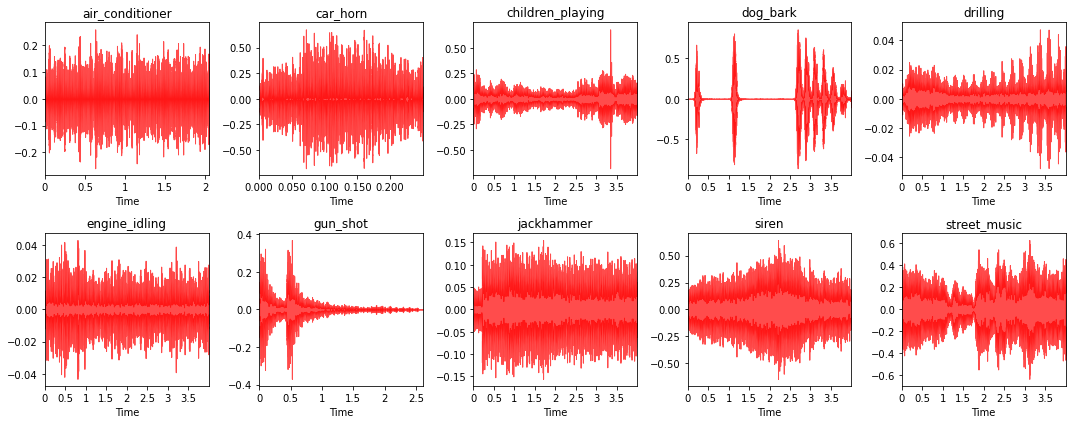

In [8]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveplot(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

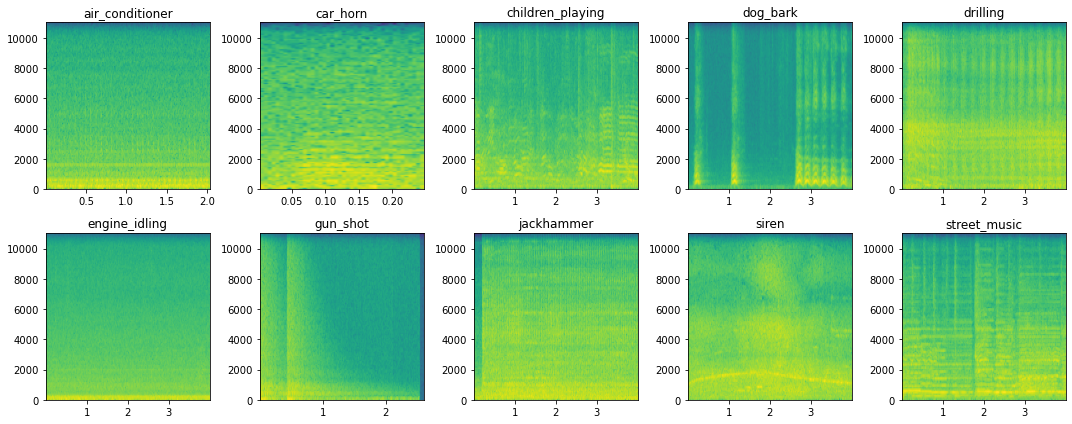

In [9]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

### Extracting features using Librosa

In [10]:
class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [11]:
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in urbansound8k.iterrows():
    
    file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [12]:
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [13]:
features = []

# Iterate through each sound file and extract the features 
for index, row in urbansound8k.iterrows():
    
    file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["classID"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

C:\Users\sanke\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
C:\Users\sanke\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\sanke\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


In [14]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

In [15]:
x_train1 = x_train 
x_test1 = x_test
y_train1 = y_train
y_test1 = y_test

In [16]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)

num_labels = yy.shape[1]
filter_size = 3

(6985, 40, 174, 1)


# CNN 2D - RELU Model

In [17]:
# Constructing model with RELu and SoftMax activation functions:
model_relu = Sequential()
model_relu.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))

model_relu.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_relu.add(MaxPooling2D(pool_size=(2,2)))
model_relu.add(Dropout(0.2))
model_relu.add(GlobalAveragePooling2D())
model_relu.add(Flatten())
model_relu.add(Dense(num_labels, activation='softmax'))

In [18]:
model_relu.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [19]:
model_relu.summary()

# Calculate pre-training accuracy 
score = model_relu.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

In [20]:
num_epochs = 100
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_relu = model_relu.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
28/28 [==============================] - 3s 53ms/step - loss: 3.6345 - accuracy: 0.2107 - val_loss: 2.0253 - val_accuracy: 0.3200

Epoch 00001: val_loss improved from inf to 2.02526, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 2/100
28/28 [==============================] - 1s 31ms/step - loss: 1.8295 - accuracy: 0.3492 - val_loss: 1.8438 - val_accuracy: 0.3784

Epoch 00002: val_loss improved from 2.02526 to 1.84376, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 3/100
28/28 [==============================] - 1s 31ms/step - loss: 1.5545 - accuracy: 0.4505 - val_loss: 1.6817 - val_accuracy: 0.3932

Epoch 00003: val_loss improved from 1.84376 to 1.68170, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 4/100
28/28 [==============================] - 1s 31ms/step - loss: 1.4072 - accuracy: 0.4941 - val_loss: 1.5286 - val_accuracy: 0.4499

Epoch 00004: val_loss improved from 1.68170 to 1.52864, saving model to saved_models\weights.

28/28 [==============================] - 1s 31ms/step - loss: 0.4815 - accuracy: 0.8379 - val_loss: 0.5648 - val_accuracy: 0.8220

Epoch 00035: val_loss improved from 0.58538 to 0.56478, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 36/100
28/28 [==============================] - 1s 31ms/step - loss: 0.4599 - accuracy: 0.8431 - val_loss: 0.5431 - val_accuracy: 0.8254

Epoch 00036: val_loss improved from 0.56478 to 0.54311, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 37/100
28/28 [==============================] - 1s 31ms/step - loss: 0.4561 - accuracy: 0.8424 - val_loss: 0.5362 - val_accuracy: 0.8266

Epoch 00037: val_loss improved from 0.54311 to 0.53622, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 38/100
28/28 [==============================] - 1s 31ms/step - loss: 0.4566 - accuracy: 0.8468 - val_loss: 0.5783 - val_accuracy: 0.8134

Epoch 00038: val_loss did not improve from 0.53622
Epoch 39/100
28/28 [===========================

28/28 [==============================] - 1s 32ms/step - loss: 0.2603 - accuracy: 0.9082 - val_loss: 0.3498 - val_accuracy: 0.8941

Epoch 00072: val_loss improved from 0.38288 to 0.34984, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 73/100
28/28 [==============================] - 1s 31ms/step - loss: 0.2572 - accuracy: 0.9108 - val_loss: 0.3937 - val_accuracy: 0.8827

Epoch 00073: val_loss did not improve from 0.34984
Epoch 74/100
28/28 [==============================] - 1s 32ms/step - loss: 0.2410 - accuracy: 0.9162 - val_loss: 0.3866 - val_accuracy: 0.8861

Epoch 00074: val_loss did not improve from 0.34984
Epoch 75/100
28/28 [==============================] - 1s 32ms/step - loss: 0.2434 - accuracy: 0.9161 - val_loss: 0.3856 - val_accuracy: 0.8884

Epoch 00075: val_loss did not improve from 0.34984
Epoch 76/100
28/28 [==============================] - 1s 32ms/step - loss: 0.2326 - accuracy: 0.9193 - val_loss: 0.3629 - val_accuracy: 0.8952

Epoch 00076: val_loss did n

In [21]:
# Evaluating the model on the training and testing set

score = model_relu.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_relu.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.972655713558197
Testing Accuracy:  0.9112764596939087


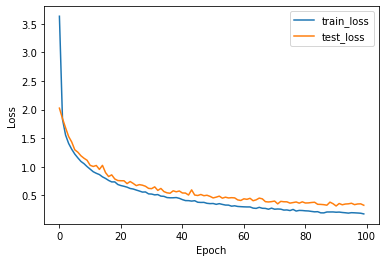

In [22]:
# Plotting Loss of CNN 2D - ReLu Model

metrics = history_relu.history
plt.plot(history_relu.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

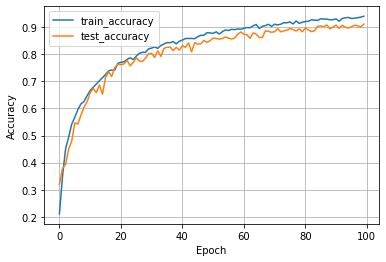

In [23]:
# Plotting Accuracy of CNN 2D - ReLu Model

plt.plot(history_relu.history['accuracy'], label='train_accuracy')
plt.plot(history_relu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# CNN 2D - ELU Model

In [24]:
# Construct model with ELU and Sigmoid activation functions:
model_elu = Sequential()
model_elu.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='elu'))
model_elu.add(BatchNormalization())
model_elu.add(MaxPooling2D(pool_size=(2,2)))
model_elu.add(Dropout(0.2))


model_elu.add(Conv2D(filters=32, kernel_size=2, activation='elu'))
model_elu.add(BatchNormalization())
model_elu.add(MaxPooling2D(pool_size=(2,2)))
model_elu.add(Dropout(0.2))


model_elu.add(Conv2D(filters=64, kernel_size=2, activation='elu'))
model_elu.add(BatchNormalization())
model_elu.add(MaxPooling2D(pool_size=(2,2)))
model_elu.add(Dropout(0.2))


model_elu.add(Conv2D(filters=128, kernel_size=2, activation='elu'))
model_elu.add(MaxPooling2D(pool_size=(2,2)))
model_elu.add(Dropout(0.2))
model_elu.add(GlobalAveragePooling2D())
model_elu.add(Flatten())
model_elu.add(Dense(num_labels, activation='softmax'))

In [25]:
model_elu.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [26]:
model_elu.summary()

# Calculate pre-training accuracy 
score = model_elu.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
batch_normalization (BatchNo (None, 39, 173, 16)       64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 85, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 42, 32)        

In [27]:
num_epochs = 100
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_elu = model_elu.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
28/28 [==============================] - 2s 54ms/step - loss: 1.8747 - accuracy: 0.3560 - val_loss: 2.4888 - val_accuracy: 0.2347

Epoch 00001: val_loss improved from inf to 2.48880, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 2/100
28/28 [==============================] - 1s 44ms/step - loss: 1.3338 - accuracy: 0.5225 - val_loss: 1.9049 - val_accuracy: 0.3744

Epoch 00002: val_loss improved from 2.48880 to 1.90486, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 3/100
28/28 [==============================] - 1s 44ms/step - loss: 1.1792 - accuracy: 0.5950 - val_loss: 1.4666 - val_accuracy: 0.4900

Epoch 00003: val_loss improved from 1.90486 to 1.46662, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 4/100
28/28 [==============================] - 1s 44ms/step - loss: 1.0853 - accuracy: 0.6233 - val_loss: 1.3494 - val_accuracy: 0.5552

Epoch 00004: val_loss improved from 1.46662 to 1.34941, saving model to saved_models\weights.

28/28 [==============================] - 1s 44ms/step - loss: 0.2959 - accuracy: 0.9031 - val_loss: 0.8554 - val_accuracy: 0.7705

Epoch 00038: val_loss did not improve from 0.79022
Epoch 39/100
28/28 [==============================] - 1s 44ms/step - loss: 0.2994 - accuracy: 0.8969 - val_loss: 0.7456 - val_accuracy: 0.7865

Epoch 00039: val_loss improved from 0.79022 to 0.74557, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 40/100
28/28 [==============================] - 1s 44ms/step - loss: 0.2930 - accuracy: 0.9014 - val_loss: 0.8109 - val_accuracy: 0.7836

Epoch 00040: val_loss did not improve from 0.74557
Epoch 41/100
28/28 [==============================] - 1s 44ms/step - loss: 0.2841 - accuracy: 0.9058 - val_loss: 0.7375 - val_accuracy: 0.7939

Epoch 00041: val_loss improved from 0.74557 to 0.73755, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 42/100
28/28 [==============================] - 1s 44ms/step - loss: 0.2742 - accuracy: 0.9085 - val_lo

28/28 [==============================] - 1s 44ms/step - loss: 0.1519 - accuracy: 0.9473 - val_loss: 0.5757 - val_accuracy: 0.8495

Epoch 00077: val_loss did not improve from 0.52555
Epoch 78/100
28/28 [==============================] - 1s 44ms/step - loss: 0.1522 - accuracy: 0.9483 - val_loss: 0.5505 - val_accuracy: 0.8580

Epoch 00078: val_loss did not improve from 0.52555
Epoch 79/100
28/28 [==============================] - 1s 44ms/step - loss: 0.1473 - accuracy: 0.9519 - val_loss: 0.5288 - val_accuracy: 0.8615

Epoch 00079: val_loss did not improve from 0.52555
Epoch 80/100
28/28 [==============================] - 1s 44ms/step - loss: 0.1498 - accuracy: 0.9485 - val_loss: 0.5496 - val_accuracy: 0.8552

Epoch 00080: val_loss did not improve from 0.52555
Epoch 81/100
28/28 [==============================] - 1s 44ms/step - loss: 0.1537 - accuracy: 0.9490 - val_loss: 0.5378 - val_accuracy: 0.8472

Epoch 00081: val_loss did not improve from 0.52555
Epoch 82/100
28/28 [==================

In [28]:
# Evaluating the model on the training and testing set
score = model_elu.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model_elu.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9445955753326416
Testing Accuracy:  0.877504289150238


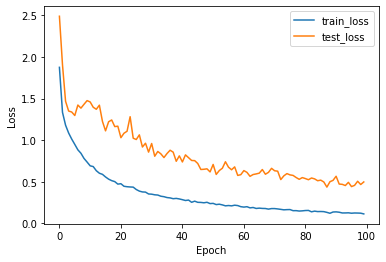

In [29]:
# Plotting Loss of CNN 2D - ELU model

metrics = history_elu.history
plt.plot(history_elu.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

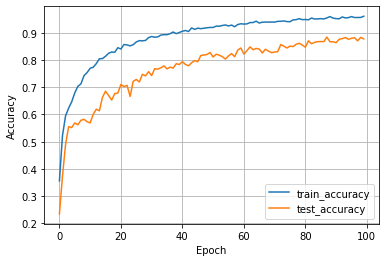

In [30]:
# Plotting Accuracy of CNN 2D - ELU Model

plt.plot(history_elu.history['accuracy'], label='train_accuracy')
plt.plot(history_elu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)